In [101]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon

In [102]:
#to convert a geographic point into a circular buffer with radius in meters.

from shapely.geometry import Point
from functools import partial
from shapely.ops import transform
import pyproj

# def buffer_in_meters(lng, lat, radius):
def buffer_in_meters(pt_latlng, radius):
    proj_meters = pyproj.Proj(init='epsg:3857')
    proj_latlng = pyproj.Proj(init='epsg:4326')
    
    project_to_meters = partial(pyproj.transform, proj_latlng, proj_meters)
    project_to_latlng = partial(pyproj.transform, proj_meters, proj_latlng)
    
#     pt_latlng = Point(lng, lat)
    pt_meters = transform(project_to_meters, pt_latlng)
    
    buffer_meters = pt_meters.buffer(radius)
    buffer_latlng = transform(project_to_latlng, buffer_meters)
    return buffer_latlng

In [103]:
gdf_county = gpd.read_file("county.zip")

<AxesSubplot:>

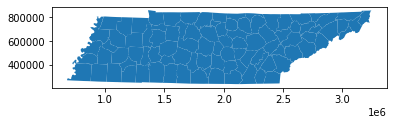

In [104]:
gdf_county.plot()

In [105]:
gdf_dav = gdf_county[gdf_county["COUNTY"] == "Davidson"]

In [106]:
gdf_dav.head()

,AREA,PERIMETER,TNCODD_,TNCODD_ID,INDEX_NO,COUNTY,STATE,geometry
30,0.136355,2.063989,32,30,63,Davidson,TN,"POLYGON ((1725320.674 734952.517, 1725410.826 ..."
49,0.000005,0.010867,51,99,63,Davidson,TN,"POLYGON ((1814456.873 657102.349, 1813945.726 ..."


In [108]:
gdf_david = gdf_dav.to_crs("EPSG:4326")
gdf_david.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [109]:
xmin, ymin, xmax, ymax = gdf_dav.total_bounds
gdf_dav.total_bounds

array([1656664.95403244,  595562.71399883, 1816136.87059501,
        755249.86127501])

In [110]:
length = 5280
wide = 5280

cols = list(np.arange(xmin, xmax + wide, wide))
print(len(cols))
rows = list(np.arange(ymin, ymax + length, length))
print(len(cols))

polygons = []
for x in cols[:-1]:
    for y in rows[:-1]:
        polygons.append(Polygon([(x,y), (x+wide, y), (x+wide, y+length), (x, y+length)]))

grid = gpd.GeoDataFrame({'geometry':polygons})
grid.to_file("grid.shp")
# grid.plot()

32
32


<AxesSubplot:>

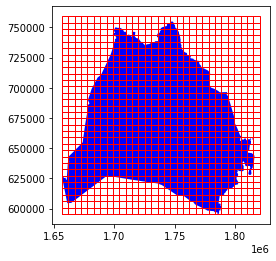

In [111]:
grid.plot(ax = gdf_dav.plot(color='blue'), color='none', edgecolor='red')

In [112]:
df_incidents = pd.read_json("incident.json")
gdf_incidents2 = gpd.GeoDataFrame(
    df_incidents, geometry=gpd.points_from_xy(df_incidents.longitude, df_incidents.latitude))
incidents = gdf_incidents2.set_crs("EPSG:4326")
incidents.head()

,ID_Original,latitude,longitude,emdCardNumber,time_utc,fireZone,time,time_local,response_time_sec,year,month,day,day_of_week,weekend_or_not,hour,window,geometry,Incident_ID,Dist_to_Seg,XDSegID
0,ObjectId(59d3a81908f47311c891f8e2),36.037228,-86.783243,29B5,1483257569507,10,1483257569507,1483235969507,268.0,2017,1,1,6,1,1,23,POINT (-86.78324 36.03723),10,13.550370,1.524394e+09
1,ObjectId(59d3a81908f47311c891f8e6),36.037414,-86.786572,29D2P,1483259455000,10,1483259455000,1483237855000,512.0,2017,1,1,6,1,2,30,POINT (-86.78657 36.03741),11,3.663952,1.524356e+09
2,ObjectId(59d3a81a08f47311c891f8ef),36.217663,-86.808699,29D1H,1483263310000,25,1483263310000,1483241710000,271.0,2017,1,1,6,1,3,43,POINT (-86.80870 36.21766),12,NaN,NaN
3,ObjectId(59d3a81a08f47311c891f8f9),36.057790,-86.739728,29D8V,1483266571867,10,1483266571867,1483244971867,366.0,2017,1,1,6,1,4,53,POINT (-86.73973 36.05779),13,NaN,NaN
4,ObjectId(59d3a81a08f47311c891f904),36.039221,-86.602785,29A2V,1483268953000,33,1483268953000,1483247353000,447.0,2017,1,1,6,1,5,61,POINT (-86.60279 36.03922),14,3.171782,4.496208e+08


In [13]:
# dav_grids = gpd.overlay(gdf_dav, grid, how='intersection')
# dav_grids.plot()

In [113]:
grids = grid.set_crs("EPSG:2274")
grids.crs

<Projected CRS: EPSG:2274>
Name: NAD83 / Tennessee (ftUS)
Axis Info [cartesian]:
- X[east]: Easting (US survey foot)
- Y[north]: Northing (US survey foot)
Area of Use:
- name: United States (USA) - Tennessee - counties of Anderson; Bedford; Benton; Bledsoe; Blount; Bradley; Campbell; Cannon; Carroll; Carter; Cheatham; Chester; Claiborne; Clay; Cocke; Coffee; Crockett; Cumberland; Davidson; De Kalb; Decatur; Dickson; Dyer; Fayette; Fentress; Franklin; Gibson; Giles; Grainger; Greene; Grundy; Hamblen; Hamilton; Hancock; Hardeman; Hardin; Hawkins; Haywood; Henderson; Henry; Hickman; Houston; Humphreys; Jackson; Jefferson; Johnson; Knox; Lake; Lauderdale; Lawrence; Lewis; Lincoln; Loudon; Macon; Madison; Marion; Marshall; Maury; McMinn; McNairy; Meigs; Monroe; Montgomery; Moore; Morgan; Obion; Overton; Perry; Pickett; Polk; Putnam; Rhea; Roane; Robertson; Rutherford; Scott; Sequatchie; Sevier; Shelby; Smith; Stewart; Sullivan; Sumner; Tipton; Trousdale; Unicoi; Union; Van Buren; Warren; Wa

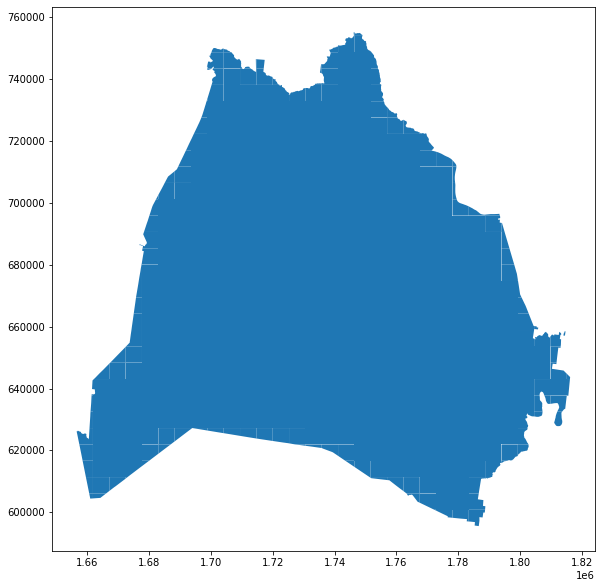

(604, 8)

In [168]:
dav_grids = gpd.overlay(gdf_dav, grids, how='intersection')
dav_grids.plot(figsize=(10, 10))
plt.show()
dav_grids.shape

In [169]:
dav_grids['grid_num'] = np.arange(len(dav_grids))

In [170]:
dav_grids2 = dav_grids.to_crs("EPSG:4326")

<AxesSubplot:>

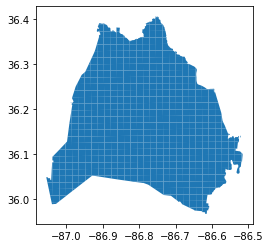

In [282]:
dav_grids2

In [314]:
joined2 = incidents.sjoin(dav_grids2, how="right")
# joined2[joined2["grid_num"]==299]

In [217]:
# joined2['row_num'] = np.arange(len(joined2))
joined2['grid_num'].nunique()
joined2.shape

(29745, 30)

In [184]:
joined2.isnull().sum(axis=1)
joined2['index_left'].isna().sum()

125

In [316]:
from datetime import datetime

timestamp = 1614452487.997
#1483286459.000
# 1483250400.000
#1483247353.000
#1483241710.000
#1483237855.000
#1483235969.507
# 1492677023.000
dt_object = datetime.fromtimestamp(timestamp)

print("dt_object =", dt_object)

dt_object = 2021-02-27 13:01:27.997000


In [24]:
# joined2.dropna(subset = ["index_left"], inplace=True)

In [185]:
joined2.grid_num.value_counts()

299    569
325    559
382    544
479    534
274    515
      ... 
240      1
241      1
242      1
258      1
603      1
Name: grid_num, Length: 604, dtype: int64

In [200]:
inc_grids = pd.Series.tolist(joined2.grid_num.value_counts())


In [201]:
inc_index = list(joined2.grid_num.value_counts().index)

In [58]:
# inc_index.sort()

In [42]:
# dax = dav_grids2.plot(figsize=(20, 20))
# joined2[joined2.row_num == 299].plot(ax = dax, figsize=(20, 20), color='red')

In [43]:
# dav_grids2["no_of_incidents"] = 0
# dav_grids2.head()

In [202]:
dav_grids2["no_of_incidents"] = 0

for i in range(len(inc_index)):
#     print("i",i)
    for j in range(dav_grids2.shape[0]):
#         print(j, joined["row_num"][j], inc_index[i], inc_grids[i])
        if (dav_grids2["grid_num"][j] == inc_index[i]):
            dav_grids2["no_of_incidents"][j]= inc_grids[i]
        
        

C:\Users\risha\AppData\Local\Programs\Python\Python37\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


<AxesSubplot:>

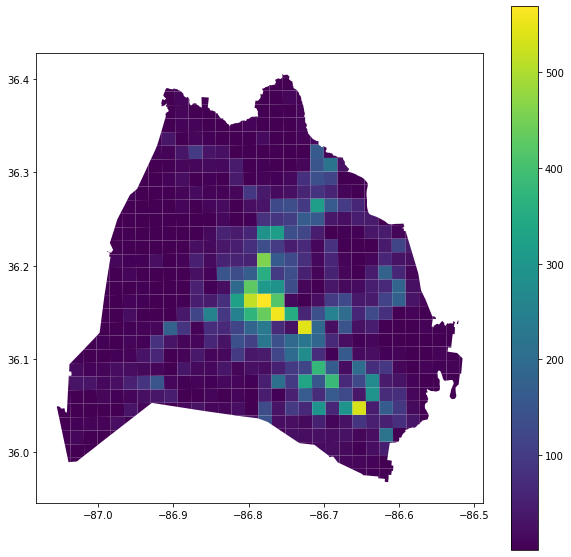

In [203]:
dav_grids2.plot(column='no_of_incidents', legend=True, figsize=(10, 10))

In [411]:
import math
start_time = 1483250400000 # 2017-01-01 00:00:00
# start_time = g_dav.time_local.min()
end_time = 1614671157253 # 2021-03-02 01:45:57.253000
# end_time = g_dav.time_local.max()

curr_time = start_time/1000
# print(start_time/1000)

incidents_per_month = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/2592000))]
incidents_per_day = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/86400))]
incidents_per_4hrs = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/14400)+10)]
print(int(math.ceil((end_time - start_time)/1000)/14400))

9126


In [412]:
counter_4hrs = 0

for i in range(0, g_dav.shape[0]):
    inc_time = (g_dav.time_local.iloc[i])/1000 #incident time #incidents.time_local
    while True:
        limit_time = curr_time +14400
#         print(inc_time-limit_time, inc_time-curr_time)
        if (inc_time < limit_time):
            incidents_per_4hrs[counter_4hrs]+=1
            break
    
        else:
            curr_time = limit_time
            counter_4hrs += 1
        
# print(counter_4hrs)
# print(incidents_per_4hrs)
sum(incidents_per_4hrs)

 

63

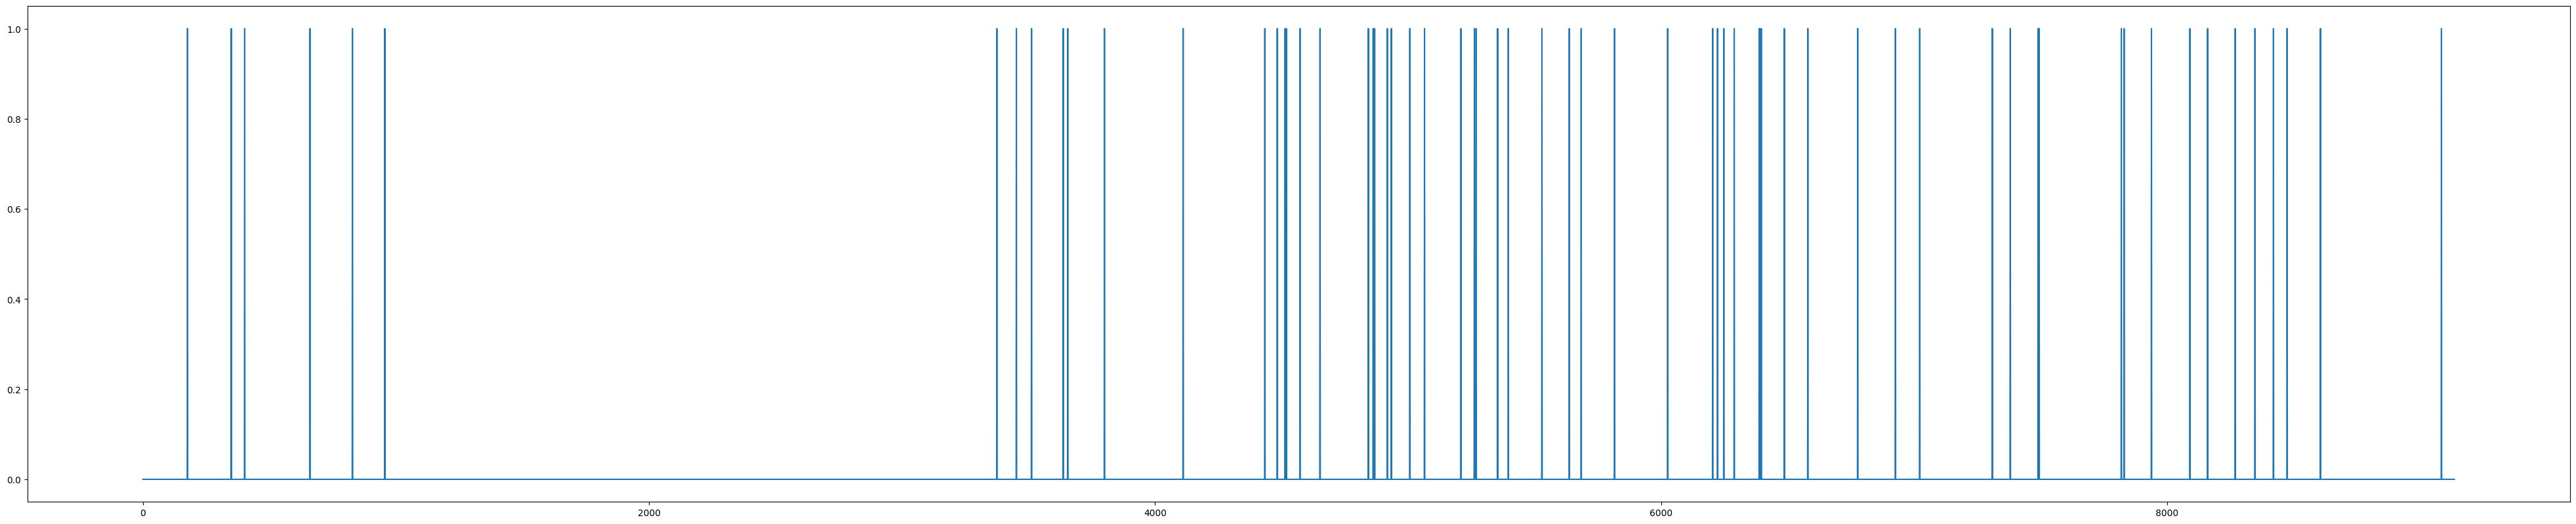

In [413]:
plt.figure(figsize=(50, 10), dpi=100)
plt.plot(incidents_per_4hrs)

In [518]:
sum_day = incidents_per_4hrs[0]
counter_day = 0
for i in range(1, counter_4hrs+1): 
    if i%6 == 0:
        incidents_per_day[counter_day] = sum_day
        counter_day+=1
        sum_day = 0
    sum_day += incidents_per_4hrs[i]
    
# print(incidents_per_day)

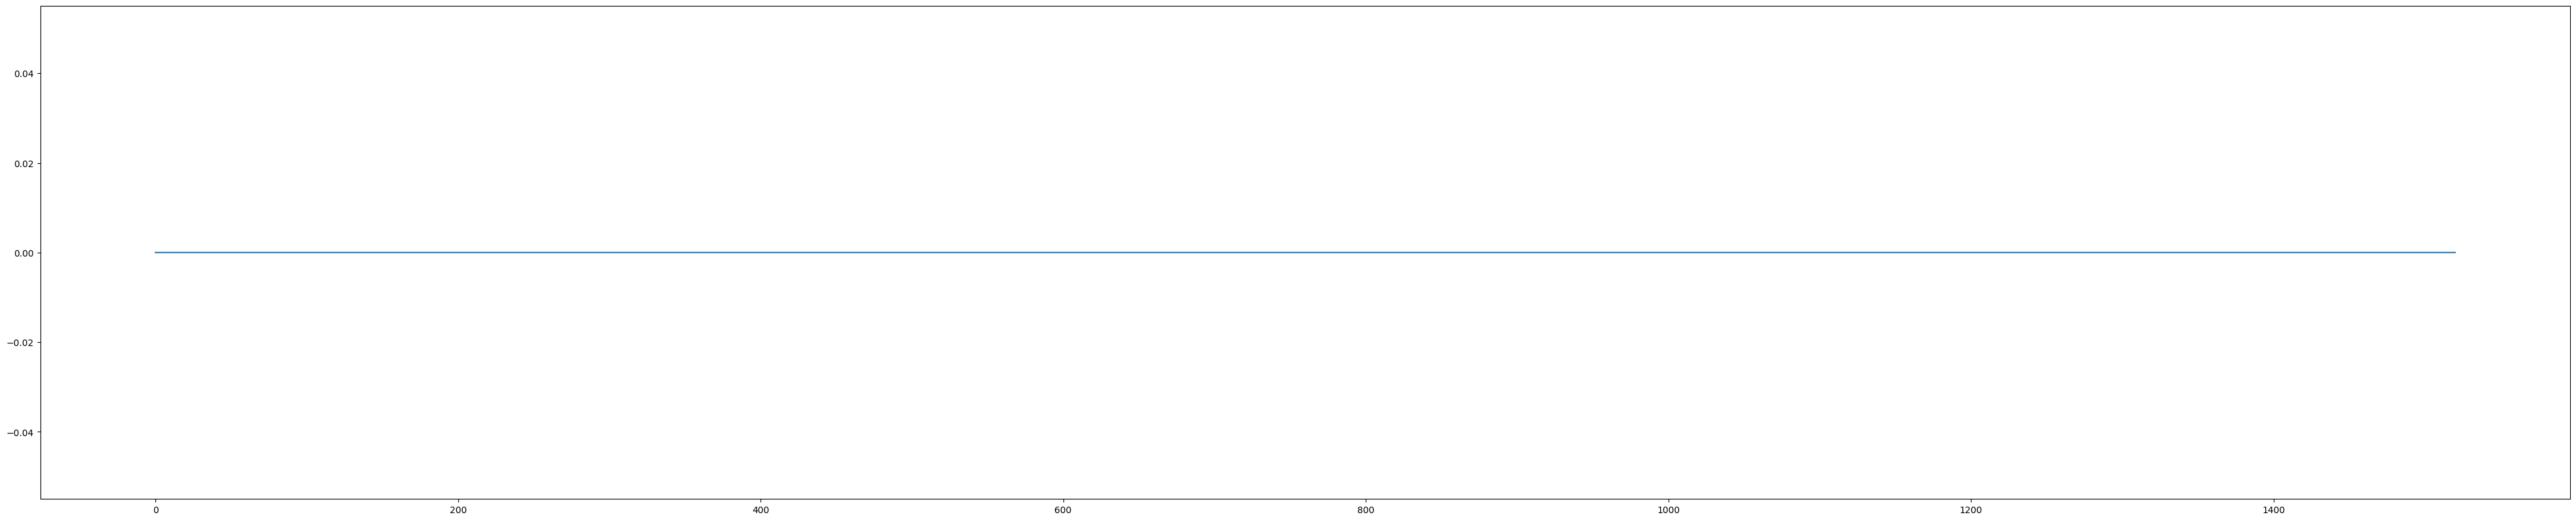

In [519]:
plt.figure(figsize=(50, 10), dpi=100)
plt.plot(incidents_per_day)

In [416]:
sum_month = incidents_per_day[0]
counter_month = 0
for i in range(1, counter_day): 
    if i%30 == 0:
        incidents_per_month[counter_month] = sum_month
        counter_month+=1
        sum_month = 0
    sum_month += incidents_per_day[i]
# print(incidents_per_month)

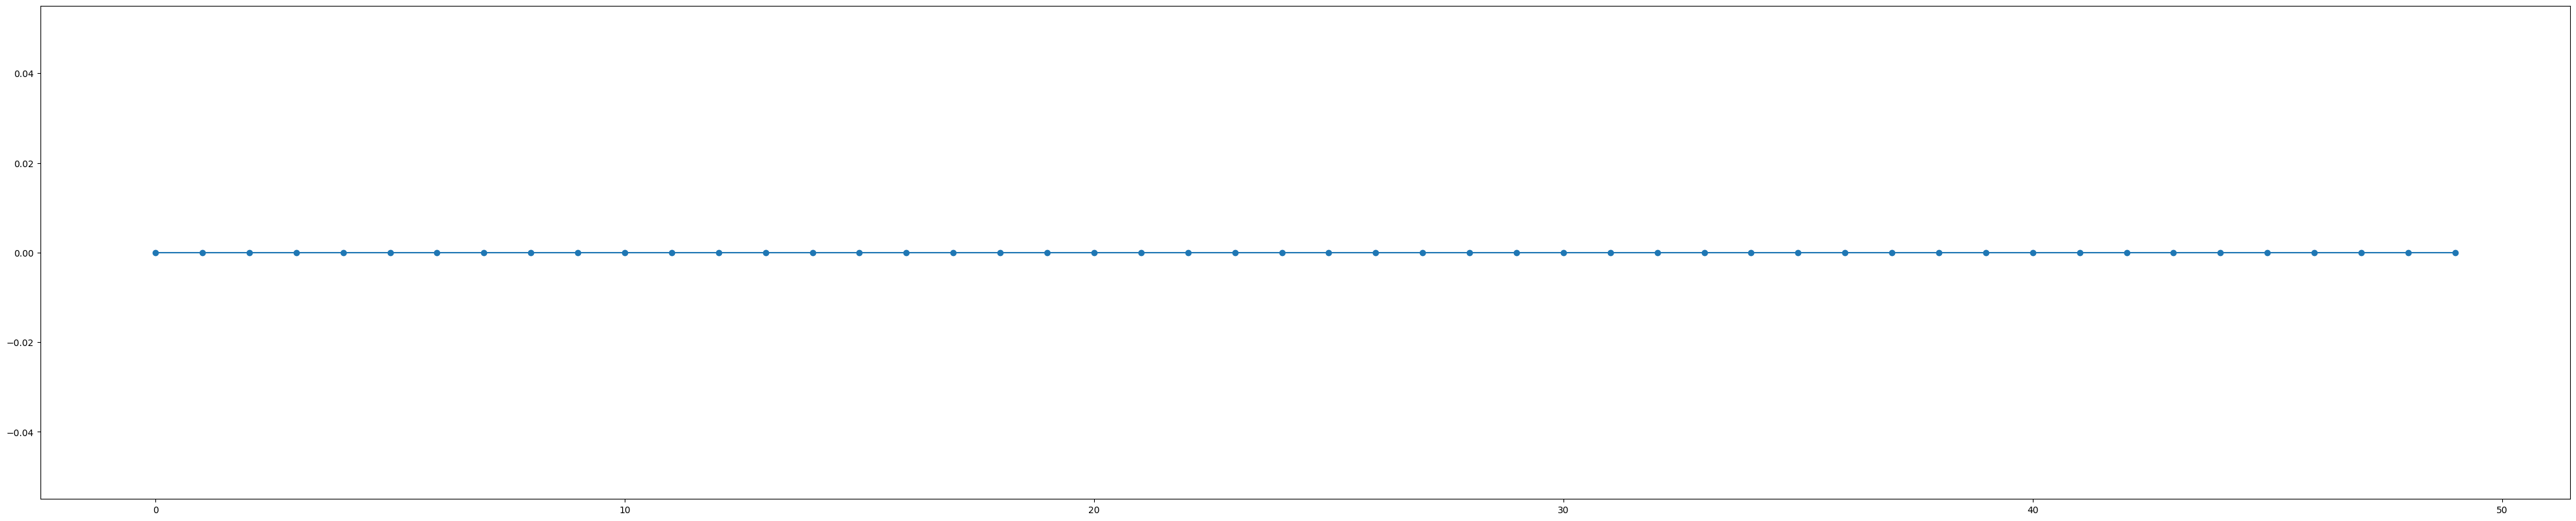

In [533]:
values = pd.date_range('2017-01-01','2021-02-01', freq='MS').strftime("%Y-%m").tolist()
# print(values)
plt.figure(figsize=(50, 10), dpi=100)
plt.plot(incidents_per_month, marker='o')
default_x_ticks = range(counter_month)
# plt.xticks(default_x_ticks,values)
plt.show()

In [410]:
g = (dav_grids2.iloc[299].geometry)
g_dav = joined2[joined2["grid_num"]==200]
g_dav.time_local.max()/1000

1614067915.55

In [335]:
g_dav[["day", "hour"]].head(20)
incidents.time_local.iloc[0]

1483235969507

<AxesSubplot:>

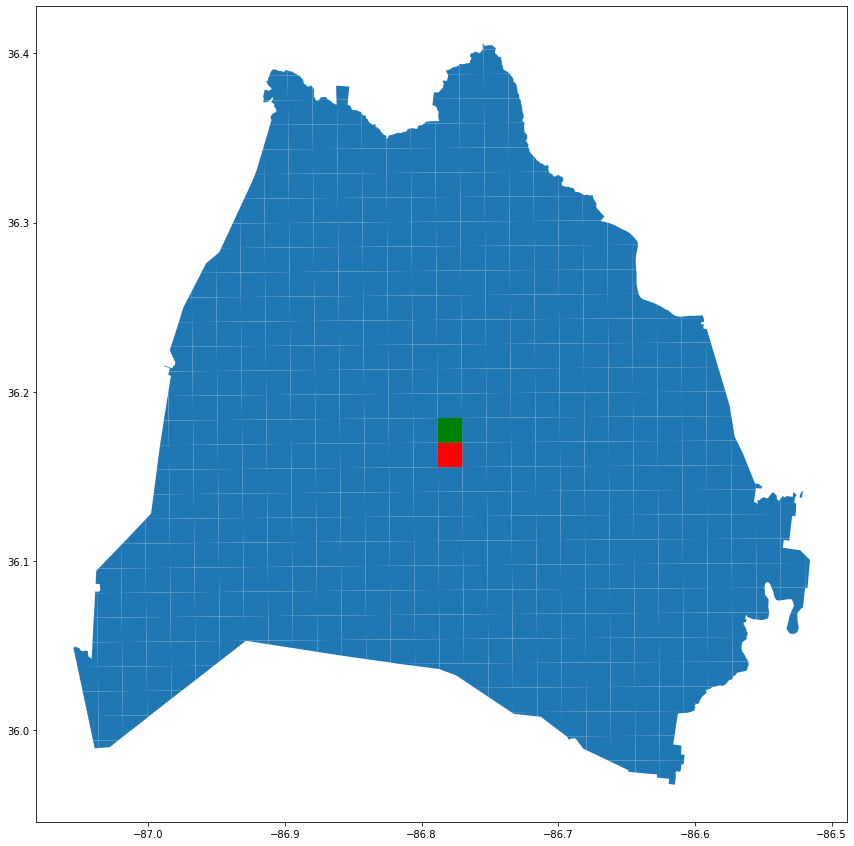

In [549]:
dav_grids3 = dav_grids2
dax = dav_grids3.plot(figsize=(15, 15))
dav_grids3[dav_grids3.grid_num == 299].plot(ax = dax, figsize=(15, 15), color='red')
dav_grids3[dav_grids3.grid_num == 300].plot(ax = dax, figsize=(20, 20), color='green')

,days,grid0,grid1,grid2,grid3,grid4,grid5,grid6,grid7,grid8,...,grid594,grid595,grid596,grid597,grid598,grid599,grid600,grid601,grid602,grid603
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1516,1516,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1517,1517,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1518,1518,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1519,1519,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [422]:
joined3 = joined2
joined3.dropna(subset = ["time_local"], inplace=True)

In [527]:
incidents_mat = [np.arange(len(incidents_per_month))]

start_time = 1483250400000 # 2017-01-01 00:00:00
end_time = 1614671157253 # 2021-03-02 01:45:57.253000
duration = int(math.ceil((end_time - start_time)/1000))
for k in range(dav_grids2.grid_num.iloc[-1]+1):
    g_dav = joined3[joined3["grid_num"]==k]
#     print(g_dav["grid_num"])
    
    curr_time = start_time/1000
    incidents_per_month = [0 for i in range(int(math.ceil((end_time - start_time)/1000)/2592000))]
    incidents_per_day = [0 for i in range(int(duration/86400))]
    incidents_per_4hrs = [0 for i in range(int(duration/14400)+10)]
    counter_4hrs = 0

    for i in range(g_dav.shape[0]):
        inc_time = (g_dav.time_local.iloc[i])/1000 #incident time #incidents.time_local
        while True:
            limit_time = curr_time +14400
    #         print(inc_time-limit_time, inc_time-curr_time)
            if (inc_time < limit_time):
                incidents_per_4hrs[counter_4hrs]+=1
#                 print("found")
                break

            else:
                curr_time = limit_time
                counter_4hrs += 1
                
    sum_day = incidents_per_4hrs[0]
    counter_day = 0
    for i in range(1, counter_4hrs+1): 
        if i%6 == 0:
            incidents_per_day[counter_day] = sum_day
            counter_day+=1
            sum_day = 0
        sum_day += incidents_per_4hrs[i]
#     print(k)
    if (k == 299):
        print(sum(incidents_per_day))
        
    sum_month = incidents_per_day[0]
    counter_month = 0
    for i in range(1, counter_day): 
        if i%30 == 0:
            incidents_per_month[counter_month] = sum_month
            counter_month+=1
            sum_month = 0
        sum_month += incidents_per_day[i]
#         print(sum_month)
        
    incidents_mat.append(incidents_per_month)

568


In [540]:
sum(incidents_mat[301])

302

In [529]:
df1 = pd.DataFrame()
# data = np.zeros((len(incidents_per_day), dav_grids2.grid_num.iloc[-1]+2))
df1 = pd.DataFrame(data = incidents_mat)
df1 = df1.transpose()
df1.columns = ["days"]+["grid"+str(i) for i in range(dav_grids2.grid_num.iloc[-1]+1)]

In [557]:
df2 = pd.DataFrame()
df2["target"] = incidents_mat[300]
df2["n"] = incidents_mat[301]
df2["nw"] = incidents_mat[276]
df2["w"] = incidents_mat[275]
df2["sw"] = incidents_mat[274]
df2["s"] = incidents_mat[299]
df2["se"] = incidents_mat[326]
df2["e"] = incidents_mat[327]
df2["ne"] = incidents_mat[328]
df = df2

In [554]:
import pandas as pd
from patsy import dmatrices
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [558]:
mask = np.random.rand(len(df)) < 0.8
df_train = df[mask]
df_test = df[~mask]
print('Training data set length='+str(len(df_train)))
print('Testing data set length='+str(len(df_test)))

Training data set length=41
Testing data set length=9


In [559]:
expr = """target ~ n  + ne + e + se + s + sw + w + nw"""

In [560]:
y_train, X_train = dmatrices(expr, df_train, return_type='dataframe')
y_test, X_test = dmatrices(expr, df_test, return_type='dataframe')

In [561]:
poisson_training_results = sm.GLM(y_train, X_train, family=sm.families.Poisson()).fit()

In [562]:
print(poisson_training_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 target   No. Observations:                   41
Model:                            GLM   Df Residuals:                       32
Model Family:                 Poisson   Df Model:                            8
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -111.84
Date:                Mon, 17 Jan 2022   Deviance:                       78.275
Time:                        04:39:10   Pearson chi2:                     73.2
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9975
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.4164      0.192      2.166      0.0

In [563]:
poisson_predictions = poisson_training_results.get_prediction(X_test)
predictions_summary_frame = poisson_predictions.summary_frame()
print(predictions_summary_frame)

         mean   mean_se  mean_ci_lower  mean_ci_upper
4   12.967058  2.133694       9.392444      17.902115
12   1.516561  0.291632       1.040340       2.210775
13   1.516561  0.291632       1.040340       2.210775
15   1.516561  0.291632       1.040340       2.210775
16   1.516561  0.291632       1.040340       2.210775
27  27.671937  5.169113      19.188245      39.906519
29  20.107436  4.180469      13.377849      30.222272
32  18.652415  5.625778      10.327688      33.687365
40   4.247332  0.765089       2.983911       6.045699


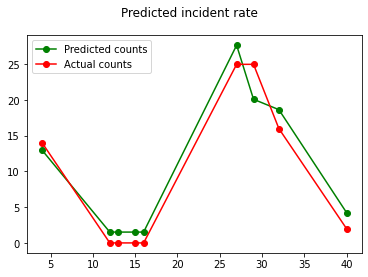

In [564]:
predicted_counts=predictions_summary_frame['mean']
actual_counts = y_test['target']
fig = plt.figure()
fig.suptitle('Predicted incident rate')
predicted, = plt.plot(X_test.index, predicted_counts, 'go-', label='Predicted counts')
actual, = plt.plot(X_test.index, actual_counts, 'ro-', label='Actual counts')
plt.legend(handles=[predicted, actual])
plt.show()